# Imports

In [2]:
import matplotlib.pyplot as plt
from os import walk
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import numpy as np
import IPython.display
from skimage.transform import radon, rescale, resize
import cv2

# Configuration

In [3]:
pic_dir = "./tomograf-zdjecia/"

# Loading and preprocess files

In [114]:
filenames = next(walk(pic_dir), (None, None, []))[2]  # [] if no file
images = dict()

for file in filenames:
    img = cv2.imread(pic_dir+file, cv2.IMREAD_GRAYSCALE)
    
    # fill backgorund
    h, w = img.shape
    diagonal = np.round(np.sqrt(h**2 + w**2)).astype(int)
    new_shape = (diagonal, diagonal)
    large_img = np.zeros(new_shape)
    x0 = (diagonal - h) // 2
    y0 = (diagonal - w) // 2
    large_img[y0:y0+h, x0:x0+w] = img
    
    images[file.split('.')[0]] = large_img


# Bresenham algorithm

In [6]:
def bresenham(p1, p2):
    assert isinstance(p1, tuple), "First argument should be tuple"
    assert isinstance(p2, tuple), "Second argument should be tuple"
    
    x1, y1 = p1
    x2, y2 = p2
    pixels = []
    dx = abs(x2-x1)
    dy = abs(y2-y1)
    
    if x1 < x2: dir_x = 1
    else: dir_x = -1
        
    if y1 < y2: dir_y = 1
    else: dir_y = -1
    
    err = dx - dy
    
    while True:
        pixels.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        e = 2 * err
        if e > -dy:
            err -= dy
            x1 += dir_x
        if e < dx:
            err += dx
            y1 += dir_y
    
    return pixels


print(bresenham((1,1), (6,5)))

[(1, 1), (2, 2), (3, 3), (4, 3), (5, 4), (6, 5)]


# Radon Transform
#### Using scikit-image function

In [89]:
n = 1 # liczba detektorów
l = 1 # rozpiętość układu emitter/detektor

@interact
def ranon_transform(image=list(images.keys()),
                    n=widgets.IntSlider(min=90,max=720,step=90,value=180),
                    l=widgets.IntSlider(min=45,max=270,step=45,value=180)):
    
    img  = rescale(images[image], scale=0.2)
    sinogram = radon(img)
    plt.imshow(sinogram, cmap='gray')
    plt.show()


interactive(children=(Dropdown(description='image', options=('CT_ScoutView', 'Kolo', 'Kwadraty2', 'SADDLE_PE-l…

# Radon transform
#### Our implementation (parallel model)

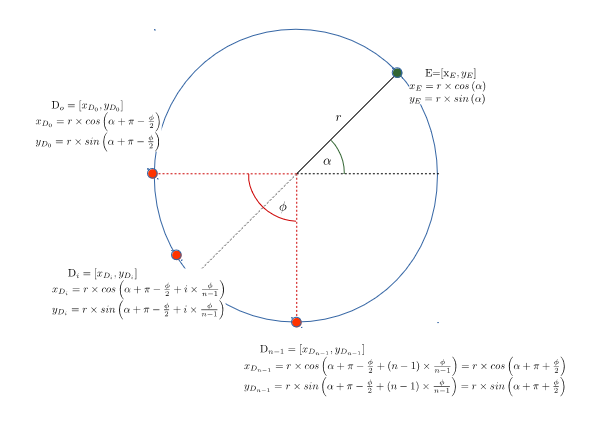
<br>
#### Choose parameters

In [6]:
delta = 0.5
phi = 250
img = images['Kropka']
detector_num = 500

In [130]:
@interact
def set_parameters(_image=list(images.keys()),
                    _detectors=widgets.IntSlider(min=100,max=1000,step=100,value=500),
                    _phi=widgets.IntSlider(min=30,max=300,step=30,value=180),
                    _delta=widgets.FloatSlider(min=0.1,max=5,step=0.1,value=1)):
    global delta, phi, detector_num, img
    delta = _delta
    phi = _phi
    detector_num = _detectors
    img = images[_image]
    
    plt.imshow(images[_image], cmap='gray')
    

interactive(children=(Dropdown(description='_image', options=('CT_ScoutView', 'Kolo', 'Kwadraty2', 'SADDLE_PE-…

#### Run radon transform

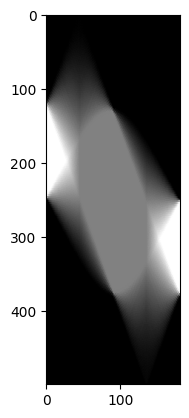

In [131]:
img  = rescale(img, scale=0.2) # little worse effect but much faster
x0, y0 = img.shape[0] // 2, img.shape[1] // 2 # center coordinates
angles = np.arange(0, 180 + delta, delta)
sinogram = np.zeros((len(angles), detector_num))
beam_points = np.zeros((len(angles), detector_num, 2, 2))
r = img.shape[0] / 2

for i, alpha in enumerate(angles):
    angles_det = np.deg2rad(np.linspace(0, phi, detector_num) + alpha - phi/2)
    angles_emit = np.deg2rad(np.linspace(0, phi, detector_num) + alpha - phi/2 + 180)

    detectors = np.zeros((detector_num, 2), dtype=int)
    emitters = np.zeros((detector_num, 2), dtype=int)
    
    for j, (angle_det, angle_emit) in enumerate(zip(angles_det, angles_emit)):
        xd = np.round(r * np.cos(angle_det) - x0).astype(int)
        yd = np.round(r * np.sin(angle_det) - y0).astype(int)
        xe = np.round(r * np.cos(angle_emit) - x0).astype(int)
        ye = np.round(r * np.sin(angle_emit) - y0).astype(int)
        detectors[j][0], detectors[j][1] = xd, yd
        emitters[detector_num-j-1][0], emitters[detector_num-j-1][1] = xe, ye
        for (ii, jj), point in zip(zip([0,0,1,1],[0,1,0,1]), [xd,yd,xe,ye]): # 00,01,10,11
            if ii == 0:
                beam_points[i, j, ii, jj] = point # detectors
            else:
                beam_points[len(angles) - i - 1, detector_num - j - 1, ii, jj] = point # emmiters
        
    pixels = np.zeros(detector_num, None)
    for j, (det_coord, emit_coord) in enumerate(zip(detectors, emitters)):
        beam_coord = bresenham(tuple(det_coord), tuple(emit_coord))
        pixels[j] = np.sum([img[coord] for coord in beam_coord])

    sinogram[i,] = pixels
    plt.imshow(sinogram.T, cmap='gray')
    plt.show()
    IPython.display.clear_output(wait=True)


# Inverse radon
#### Our implementation (in progress)

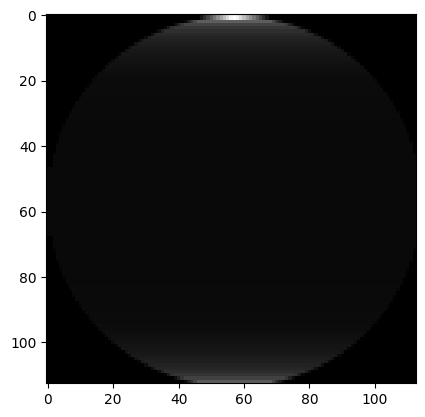

In [132]:
reconstructed_img = np.zeros(img.shape)
count_points = np.zeros(img.shape)

for i in range(sinogram.shape[0]):
    for j in range(detector_num):
        det_coord, emit_coord = beam_points[i,j]
        points = bresenham(tuple(emit_coord), tuple(det_coord))
        for point in points:
            #x, y = int(point[0]) + img.shape[0], int(point[1]) + img.shape[1]
            x, y = int(point[0]), int(point[1])
            #if x < img.shape[0] and y < img.shape[1]:
            count_points[x,y] += 1
            reconstructed_img[x,y] += sinogram[i,j]
                
        
    plt.imshow(reconstructed_img, cmap='gray')
    plt.show()   
    IPython.display.clear_output(wait=True)


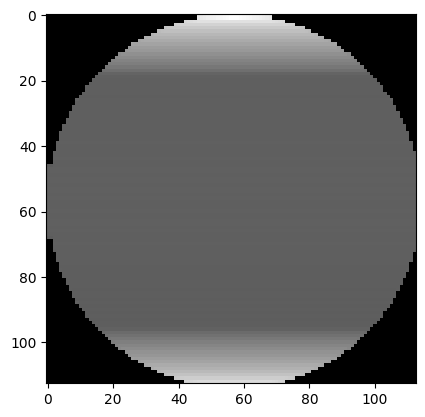

In [133]:
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if count_points[i,j] != 0:
            reconstructed_img[i,j] /= count_points[i,j]
        else:
            reconstructed_img[i,j] = 0
plt.imshow(reconstructed_img,cmap='gray')

#### Using skimage built-in function

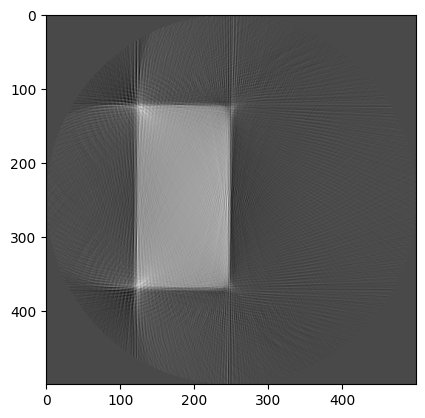

In [134]:
from skimage.transform import iradon
reconstructed_img = iradon(sinogram.T)
plt.imshow(reconstructed_img, cmap='gray')
plt.show()

In [10]:
# http://rknet.pl/student/2013_2014/pom/wyk/POM_Radon_Hough.pdf
# https://scikit-image.org/docs/stable/auto_examples/transform/plot_radon_transform.html